# Snapshot waveform tutorial

## Load `pybhpt.geo` and `pybhpt.teuk`

In [1]:
from pybhpt.teuk import TeukolskyMode
from pybhpt.geo import KerrGeodesic
from pybhpt.swsh import SpinWeightedSpheroidalHarmonic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Building a snapshot waveform

We can build a snapshot waveform produced by a point-particle on a periodic geodesic in Kerr spacetime from the Teukolsky solutions. The snapshot waveform $h = h_+ - i h_\times$ is related to Teukolsky solutions by $\psi_4(r\rightarrow\infty) = \frac{1}{2}\ddot{h}$, leading to 
$$\begin{align}
    h &= - \frac{2\mu}{r} \sum_{jmkn} \frac{Z^\mathrm{Up}_{jmkn}}{\omega_{mkn}^2} S_{jm\gamma_{mkn}}(\theta)e^{im\phi} e^{-i\omega_{mkn}u}
\end{align}$$
where $u=t-r_*$.

First we define a background geodesic

In [2]:
a, p, e, x = 0.99, 5, 0.6, 0.4
geo = KerrGeodesic(a, p, e, x, nsamples = 2**8)

We now build the waveform, starting with computing all amplitudes which contribute to the total power above some threshold tolerance `tol`

To facilitate the sum over $k$, and $n$, we build some functions for computing the amplitudes and checking their relative strength to the sum of the squared amplitudes

In [3]:
def k_mode_sum(j, m, n, geo, modes, n_total_power_sq, total_power_sq, tol = 1e-5, klimit = 10):
    """
    This function computes the sum over $k$-modes for a given set 
    of indices $(j, m, n)$ and a geodesic object. 
    It iteratively solves the Teukolsky equation for each $k$-mode,
    computes the amplitude, and accumulates the squared power 
    until the relative contribution of new modes falls below a 
    specified tolerance. The function handles both positive 
    and negative $k$ values, skipping unphysical cases. 
    Results are appended to the `modes` list 
    and the total power is updated.

    Parameters:
    ===========
    - `j, m, n`: Mode indices
    - `geo`: KerrGeodesic object
    - `modes`: List to store mode results
    - `n_total_power_sq`: Accumulated power for this $n$
    - `total_power_sq`: Accumulated total power
    - `tol`: Relative tolerance for convergence (default: 1e-5)
    - `klimit`: Maximum $|k|$ value to sum (default: 10)

    Returns:
    ========
    - Updated `modes` list
    - Updated `n_total_power_sq`
    - Updated `total_power_sq`
    """
    
    kerror = 1
    kconverge = 0
    k0 = -m
    k = k0
    nk_total_power_sq_prev = 1
    while (k < klimit) and (kconverge < 3):
        if (m == 0) and (n == 0) and (k <= 0):
            k += 1
        else:
            Psis = TeukolskyMode(-2, j, m, k, n, geo)
            Psis.solve(geo)
            amp = -2*Psis.amplitude('Up')/Psis.frequency**2
            if Psis.precision('Up') > 0.01:
                amp = 0

            nk_total_power_sq = np.abs(amp)**2
            n_total_power_sq += nk_total_power_sq
            total_power_sq += nk_total_power_sq

            kerror = np.sqrt(nk_total_power_sq/total_power_sq)
            if (kerror < tol) and (nk_total_power_sq_prev >= nk_total_power_sq):
                kconverge += 1
            else:
                kconverge = 0
            modes.append([j, m, k, n, Psis.frequency, amp])
            k += 1
            nk_total_power_sq_prev = nk_total_power_sq
    # print(n, k-1)

    k = k0 - 1
    kconverge = 0
    nk_total_power_sq_prev = 1
    while (np.abs(k) < klimit) and (kconverge < 3):
        if (m == 0) and (n == 0) and (k <= 0):
            k -= 1
        else:
            Psis = TeukolskyMode(-2, j, m, k, n, geo)
            Psis.solve(geo)
            amp = -2*Psis.amplitude('Up')/Psis.frequency**2
            if Psis.precision('Up') > 0.01:
                amp = 0

            nk_total_power_sq = np.abs(amp)**2
            n_total_power_sq += nk_total_power_sq
            total_power_sq += nk_total_power_sq

            kerror = np.sqrt(nk_total_power_sq/total_power_sq)
            if (kerror < tol) and (nk_total_power_sq_prev >= nk_total_power_sq):
                kconverge += 1
            else:
                kconverge = 0
            modes.append([j, m, k, n, Psis.frequency, amp])
            k -= 1
            nk_total_power_sq_prev = nk_total_power_sq
    # print(n, k+1)

    return modes, n_total_power_sq, total_power_sq

In [4]:
def n_mode_sum(j, m, geo, modes, m_total_power_sq, total_power_sq, tol = 1e-5, nlimit = 50, klimit = 10):
    """
    This function computes the sum over $n$-modes for a given
    $(j, m)$ and geodesic object. For each $n$-mode, it calls 
    `k_mode_sum` to perform the $k$-sum, accumulates the squared 
    power, and checks for convergence. Both positive and negative 
    $n$ values are considered, skipping unphysical cases. Results 
    are appended to the `modes` list and the total power is updated.

    Parameters:
    ===========
    - `j, m`: Mode indices
    - `geo`: KerrGeodesic object
    - `modes`: List to store mode results
    - `m_total_power_sq`: Accumulated power for this $m$
    - `total_power_sq`: Accumulated total power
    - `tol`: Relative tolerance for convergence (default: 1e-5)
    - `nlimit`: Maximum $|n|$ value to sum (default: 50)
    - `klimit`: Maximum $|k|$ value to sum (default: 10)

    Returns:
    ========
    - Updated `modes` list
    - Updated `m_total_power_sq`
    - Updated `total_power_sq`
    """
    n0 = 0
    n = n0
    nconverge = 0
    n_total_power_sq_prev = 1
    while (n < nlimit) and (nconverge < 3):
        if (m == 0) and (n < 0):
            n += 1
        else:
            n_total_power_sq = 0.
            modes, n_total_power_sq, total_power_sq = k_mode_sum(j, m, n, geo, modes, n_total_power_sq, total_power_sq, tol=tol, klimit=klimit)
            m_total_power_sq += n_total_power_sq

            nerror = np.sqrt(n_total_power_sq/total_power_sq)
            if (nerror < tol) and (n_total_power_sq_prev >= n_total_power_sq):
                nconverge += 1
            else:
                nconverge = 0
            n += 1
            n_total_power_sq_prev = n_total_power_sq
    # print(n-1)

    n = n0 - 1
    nconverge = 0
    n_total_power_sq_prev = 1
    while (np.abs(n) < nlimit) and (nconverge < 3):
        if (m == 0) and (n < 0):
            n -= 1
        else:
            n_total_power_sq = 0.
            modes, n_total_power_sq, total_power_sq = k_mode_sum(j, m, n, geo, modes, n_total_power_sq, total_power_sq, tol=tol, klimit=klimit)
            m_total_power_sq += n_total_power_sq

            nerror = np.sqrt(n_total_power_sq/total_power_sq)
            if (nerror < tol) and (n_total_power_sq_prev >= n_total_power_sq):
                nconverge += 1
            else:
                nconverge = 0
            n -= 1
            n_total_power_sq_prev = n_total_power_sq
    # print(n+1)

    return modes, m_total_power_sq, total_power_sq

We then specify the tolerance of the amplitude power we want to include in the waveform. To speed up calculations, we set it to 0.01

In [5]:
tol = 1e-2

We then produce all of the relevant modes and store them in a list `modes`. (This can take several minutes depending on the tolerance set and the nature of the source.)

In [6]:
total_power_sq = 0.
nlimit = 120
klimit = 40

modes = []
jerror = 1
j = 2
jmax = 10
while (j <= jmax) and (jerror > tol):
    m = j
    j_total_power_sq = 0.
    mconvergence = 0
    while m >= 0 and mconvergence < 2:     
        print(j, m)

        m_total_power_sq = 0.
        modes, m_total_power_sq, total_power_sq = n_mode_sum(j, m, geo, modes, m_total_power_sq, total_power_sq, tol=tol, nlimit=nlimit, klimit=klimit)
        j_total_power_sq += m_total_power_sq

        merror = np.sqrt(m_total_power_sq/total_power_sq)
        if merror < tol:
            mconvergence += 1
        else:
            mconvergence = 0
        m -= 1
        # print(np.sqrt(m_total_power_sq))
    jerror = np.sqrt(j_total_power_sq/total_power_sq)
    # print(j, jerror, tol, jerror > tol, np.sqrt(total_power_sq))
    j += 1

2 2
2 1
2 0
3 3
3 2
3 1
3 0
4 4
4 3
4 2
4 1
4 0
5 5
5 4
5 3
5 2
5 1
5 0
6 6
6 5


We specify the time samples for computing the waveform, along with the polar viewing angles

In [7]:
th = 0.4
phi = 0.2
u_grid = np.linspace(0, 4*2*np.pi/geo.frequencies[0], 800)

We then build the waveform from the selected mode amplitudes

In [8]:
h = 0.j
for mode in modes:
    j, m, k, n, omega, amp = mode
    Slm = SpinWeightedSpheroidalHarmonic(-2, j, m, a*omega)(th)
    h += amp * Slm * np.exp(1j * (m * phi - omega * u_grid))
    Slm = SpinWeightedSpheroidalHarmonic(-2, j, -m, -a*omega)(th)
    h += (-1)**(j + k) * np.conj(amp) * Slm * np.exp(-1j * (m * phi - omega * u_grid))

Plotting the waveform

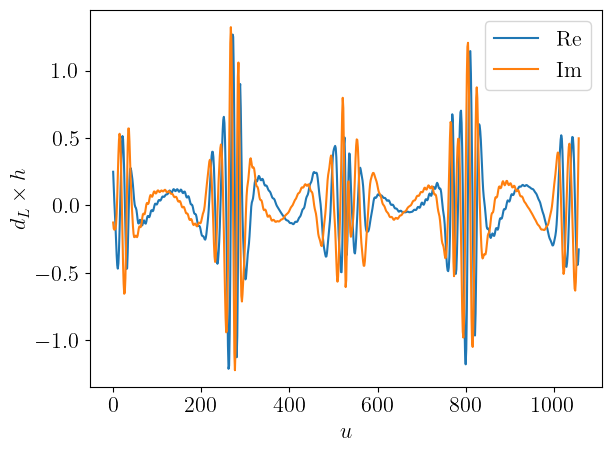

In [9]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

plt.plot(u_grid, h.real, label='Re')
plt.plot(u_grid, h.imag, label='Im')
plt.xlabel(r'$u$')
plt.ylabel(r'$d_L \times h$')
plt.legend()
plt.tight_layout()
plt.show()

Note that the residual high-frequency oscillations can be mitigated by reducing the value of `tol`